# Backpropagation algorithm

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from IPython.display import display
import datetime as dt 
import random
from back_prop_utils import H_th_function, grid_search, round_to_sig_figs
from loss_functions import loss
from models import TransferFunctionModel

In [2]:
# TODO: Implement this with torch for consistency, make routine for unwrapping with torch/numpy

# frequency range
interp = 2**6
freqs_THz = np.linspace(0.1, 5, interp)   # 0-5 THz 
freqs = freqs_THz * 1e12
freqs_ang = freqs * 2 * np.pi 
w_tensor = torch.tensor(freqs_ang, dtype=torch.float32)

# Generate random n, k, d
n_lims = [2, 4]
k_lims = [-0.1, 0]
d_lims = [300e-6, 500e-6]

# Define significant figures for each parameter
n_sig_figs = 6
k_sig_figs = 6
d_sig_figs = 6

# Generate data point
n = random.uniform(*n_lims)
k = random.uniform(*k_lims)
d = random.uniform(*d_lims)

# Apply significant figures
n_actual = round_to_sig_figs(n, n_sig_figs)
k_actual = round_to_sig_figs(k, k_sig_figs)
d_actual = round_to_sig_figs(d, d_sig_figs)

tf_values = H_th_function((n_actual+k_actual*1j), w_tensor, d_actual)  # Use torch tensor for w

H_values_clean = np.abs(tf_values)
phi_values_clean = np.unwrap(np.angle(tf_values))
phi_exp_tensor = torch.tensor(phi_values_clean, dtype=torch.float32) # convert back to tensor

# add noise or actual signals
H_values = H_values_clean + np.random.normal(0, 0.005, size=len(H_values_clean))
phi_values = phi_exp_tensor + np.random.normal(0, 1, size=len(phi_values_clean))

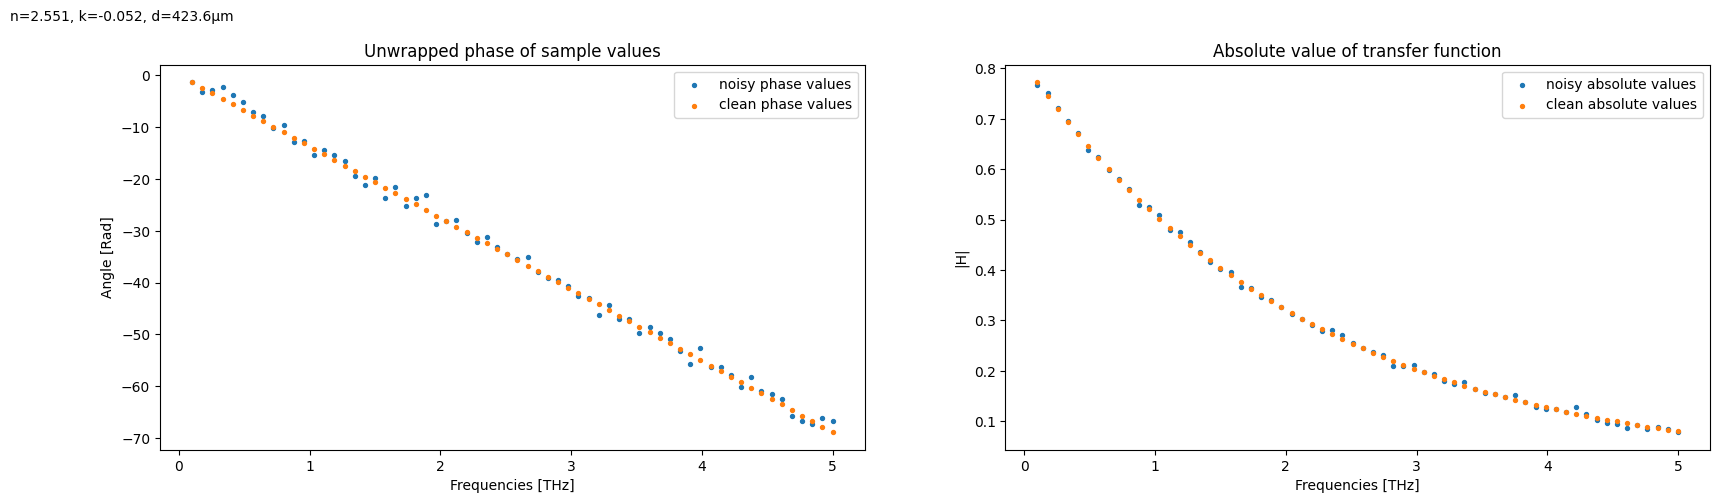

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].scatter(freqs_THz, phi_values, s=8, label='noisy phase values')
axs[0].scatter(freqs_THz, phi_values_clean, s=8, label='clean phase values')
axs[0].set_title('Unwrapped phase of sample values')
axs[0].set_xlabel('Frequencies [THz]')
axs[0].set_ylabel('Angle [Rad]')

axs[1].scatter(freqs_THz, H_values, s=8, label='noisy absolute values')
axs[1].scatter(freqs_THz, H_values_clean, s=8, label='clean absolute values')
axs[1].set_title('Absolute value of transfer function')
axs[1].set_xlabel('Frequencies [THz]')
axs[1].set_ylabel('|H|')

# Annotate with n, k, d values
axs[1].set_ylabel('|H|')

# Add a label at the top-left of the entire figure (outside the subplots)
fig.text(0.05, 0.99, f'n={n:.3f}, k={k:.3f}, d={1e6*d:.1f}µm', 
         verticalalignment='top', horizontalalignment='left', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

axs[0].legend()
axs[1].legend()
plt.show()

In [4]:
# Perform grid-search for params
#grid_search(n0=2.0, k0=-0.05, d0=0.0004, H_values=H_values, phi_values=phi_values, freqs_ang=freqs_ang, H_th_function=H_th_function, loss=loss, verbose=True)

## Logarithmic parameterization

## Regular parameterization

In [5]:
# Initialize model and optimizer
model = TransferFunctionModel(w_tensor=w_tensor, d=d_actual) # initialize with frequency range.
optimizer = torch.optim.Adam(model.parameters(), lr=10e-6)

# Training Loop
num_epochs = 10000
loss_plot = []
l = np.Inf
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Compute predicted transfer function
    H_pred = model()

    # Compute amplitude and phase
    H_pred_amp = torch.abs(H_pred)
    H_pred_phase = torch.angle(H_pred)

    # Unwrap the phase using NumPy
    H_pred_phase_unwrapped = np.unwrap(H_pred_phase.detach().cpu().numpy())  # Convert to NumPy, unwrap, and convert back to tensor

    # Convert the unwrapped phase back to a PyTorch tensor
    H_pred_phase_unwrapped = torch.tensor(H_pred_phase_unwrapped, dtype=torch.float32).to(H_pred.device)

    l = loss(H_values, H_pred_amp, phi_values, H_pred_phase_unwrapped)
    loss_plot.append(l.item())
    # Backpropagation
    l.backward()
    optimizer.step()

    # Print progress
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {l.item()}")

# Optimized parameters
print(f"Optimized n: {model.n.item()}, k: {model.k.item()}")

Epoch 0: Loss = 10.463854354990545
Epoch 500: Loss = 10.36385876635909
Epoch 1000: Loss = 10.260643086716346
Epoch 1500: Loss = 10.152137177152373
Epoch 2000: Loss = 10.041590155771747
Epoch 2500: Loss = 9.929994900099747
Epoch 3000: Loss = 9.816778273525461
Epoch 3500: Loss = 9.703539069014415
Epoch 4000: Loss = 9.590298270428367
Epoch 4500: Loss = 9.477055193943716
Epoch 5000: Loss = 9.363817752891965
Epoch 5500: Loss = 9.25057722831245
Epoch 6000: Loss = 9.137337236868962
Epoch 6500: Loss = 9.024100243317708
Epoch 7000: Loss = 8.910855995229259
Epoch 7500: Loss = 8.797616985830292
Epoch 8000: Loss = 8.684377135993982
Epoch 8500: Loss = 8.571133303543366
Epoch 9000: Loss = 8.457891341933118
Epoch 9500: Loss = 8.344651674473472
Optimized n: 2.9013755321502686, k: -0.049025002866983414


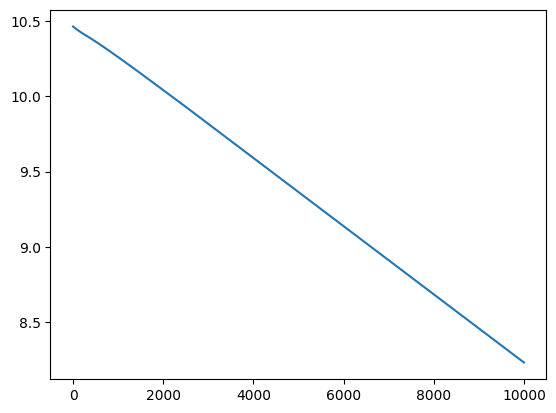

In [6]:
plt.plot(loss_plot)

In [7]:
# TODO: 
# Test the outputs by plotting.
# Test different initial conditions.
# Create training plots.

